In [1]:
import os
import sys
cwd = os.getcwd()
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, os.path.join(cwd, "../"))

import pickle
import torch
import importlib
import numpy as np
import pandas as pd
import copy

import src.bin.tensorify as tensorify
import src.utils.data_conversion_utils as conversions
import src.data_manager.student_life_var_binned_data_manager as data_manager
import src.bin.trainer as trainer

from sklearn import metrics

from torch import nn
from copy import copy
from copy import deepcopy
from src import definitions
from src.bin import validations
from src.bin import statistics
from src.bin import plotting
from src.utils.read_utils import read_pickle
from src.utils import student_utils
from src.data_manager import sub_sampler
from src.data_manager import cross_val
from src.data_manager import helper as data_manager_helper
from tabulate import tabulate
from src.models.multitask_learning import multitask_autoencoder 
from src.models import user_dense_heads


pd.set_option('max_rows', 10000)

importlib.reload(validations)
importlib.reload(multitask_autoencoder)
importlib.reload(user_dense_heads)
importlib.reload(sub_sampler)
importlib.reload(statistics)
importlib.reload(cross_val)
importlib.reload(definitions)
importlib.reload(conversions)
importlib.reload(tensorify)
importlib.reload(plotting)
importlib.reload(trainer)
importlib.reload(data_manager)
importlib.reload(student_utils)
importlib.reload(data_manager_helper)
feature_list = data_manager.FEATURE_LIST

In [2]:
###### Pickle #####
data = read_pickle('../data/training_data/shuffled_splits/training_date_normalized_shuffled_splits_select_features.pkl')

#### Data ####
# student_list = student_list =  [53, 46, 7, 49, 22, 24, 2]
# # student_list = [2]
# data = data_manager.get_data_for_training_in_dict_format(*student_list, normalize=True, 
#                                                          fill_na=True, flatten_sequence=False)

# ###### Randomize ######
# train_ids, val_ids, test_ids = cross_val.random_stratified_splits(data)
# data['train_ids'] = train_ids
# data['val_ids'] = val_ids
# data['test_ids'] = test_ids

# data = sub_sampler.get_sub_sampled_sequences(data)

############# Stats ############# 
# unnormalized_data = data_manager.get_data_for_training_in_dict_format(*student_list, normalize=False, fill_na=False)
# statistics_df, raw_df = statistics.get_statistics_on_data_dict(unnormalized_data, feature_list)
# print(statistics.get_train_test_val_label_counts_from_raw_data(data))


#### Data ####
# student_list =  [1, 2, 4 , 7,10, 22, 24, 33, 42, 46, 49, 53, 57 ]
# data = data_manager.get_data_for_training_in_dict_format(*student_list, normalize=True, 
#                                                          fill_na=True, flatten_sequence=False)

# ###### Randomize ######
# train_ids, val_ids, test_ids = cross_val.random_stratified_splits(data, stratify_by='students')
# data['train_ids'] = train_ids
# data['val_ids'] = val_ids
# data['test_ids'] = test_ids

# data = sub_sampler.get_sub_sampled_sequences(data)

############ Stats ############# 
# unnormalized_data = data_manager.get_data_for_training_in_dict_format(*student_list, normalize=False, fill_na=False)
# statistics_df, raw_df = statistics.get_statistics_on_data_dict(unnormalized_data, feature_list)
print(statistics.get_train_test_val_label_counts_from_raw_data(data))

      Train    Val    Test
--  -------  -----  ------
 0      111     45      29
 1      123     55      38
 2       93     30      21


In [3]:
################################## Init ##################################
use_historgram = True
autencoder_bottle_neck_feature_size = 128
autoencoder_num_layers = 1
alpha , beta = 0.0001, 1
decay = 0.0001
first_key = next(iter(data['data'].keys()))
if use_historgram:
    num_features = len(data['data'][first_key][4][0])
else:
    num_features = len(data['data'][first_key][0][0])
num_covariates = len(data['data'][first_key][definitions.COVARIATE_DATA_IDX])
shared_hidden_layer_size = 256
user_dense_layer_hidden_size = 64
num_classes = 3
learning_rate = 0.000005
n_epochs = 300
shared_layer_dropout_prob=0.10
user_head_dropout_prob=0.0
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')

print("Num Features:", num_features)
print("Device: ", device)

Num Features: 9
Device:  cuda


In [4]:
class_weights = torch.tensor(statistics.get_class_weights_in_inverse_proportion(data))
cuda_enabled = torch.cuda.is_available()
data = tensorify.tensorify_data_gru_d(data, cuda_enabled)

In [1]:
student_list = conversions.extract_distinct_student_idsfrom_keys(data['data'].keys())
ordinal_regression = True
model = multitask_autoencoder.MultiTaskAutoEncoderLearner(
                               conversions.prepend_ids_with_string(student_list, "student_"),
                               num_features,
                               autencoder_bottle_neck_feature_size,
                               autoencoder_num_layers,
                               shared_hidden_layer_size,
                               user_dense_layer_hidden_size,
                               num_classes,
                               num_covariates,
                               shared_layer_dropout_prob,
                               user_head_dropout_prob,
                               ordinal_regression)

if cuda_enabled:
    model.cuda()
    class_weights = class_weights.cuda()

reconstruction_criterion = torch.nn.L1Loss(reduction="sum")
classification_criterion = torch.nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)

NameError: name 'conversions' is not defined

xxxxxxxxxxxxxx epoch: 0 xxxxxxxxxxxxxx


/home/abhinavshaw/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/abhinavshaw/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/abhinavshaw/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/abhinavshaw/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


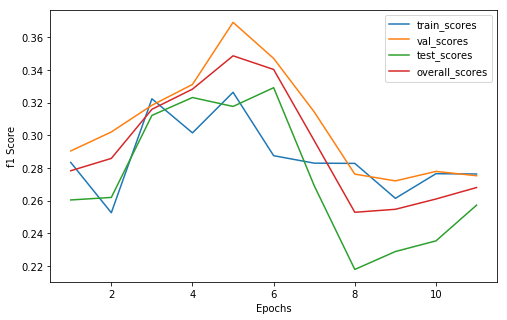

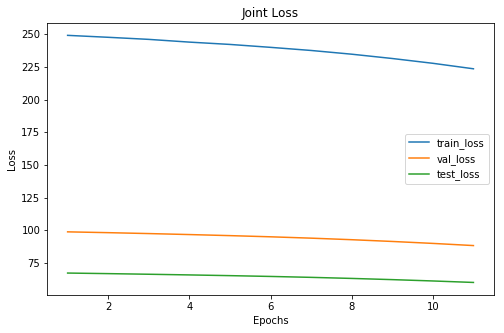

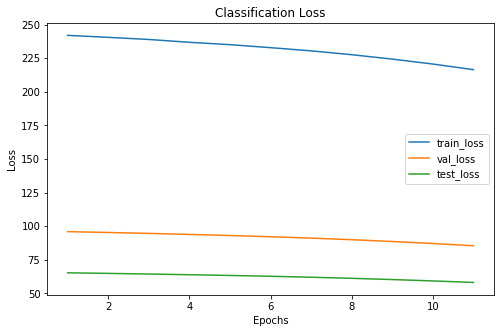

Cofusion Matrix For Val Set: 
-  --  --  -
0  26  19  0
0  24  27  4
0   6  19  5
0   0   0  0
-  --  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0        0      0       0
 1      135     56      38
 2      167     65      45
xxxxxxxxxxxxxx epoch: 1 xxxxxxxxxxxxxx


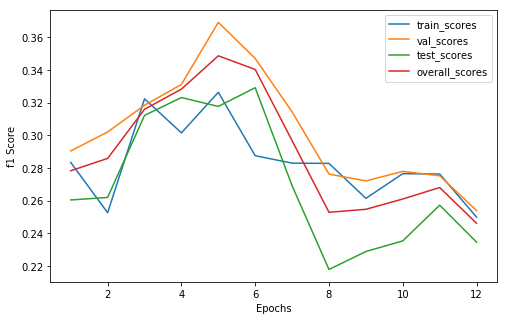

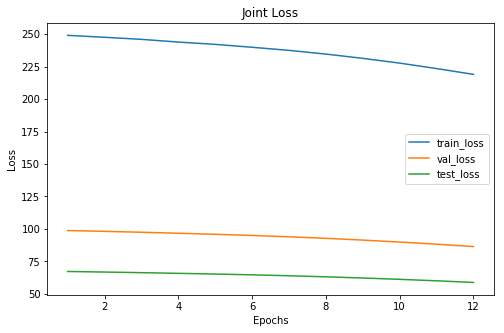

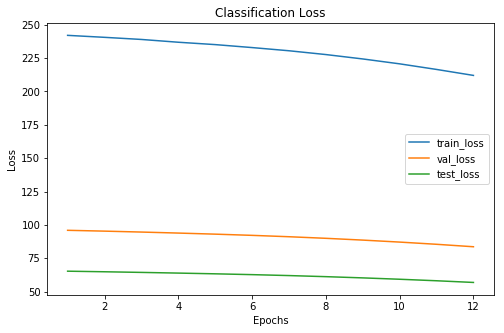

Cofusion Matrix For Val Set: 
-  --  --  -
0  23  22  0
0  20  31  4
0   5  20  5
0   0   0  0
-  --  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0        0      0       0
 1      124     48      33
 2      180     73      49
xxxxxxxxxxxxxx epoch: 2 xxxxxxxxxxxxxx


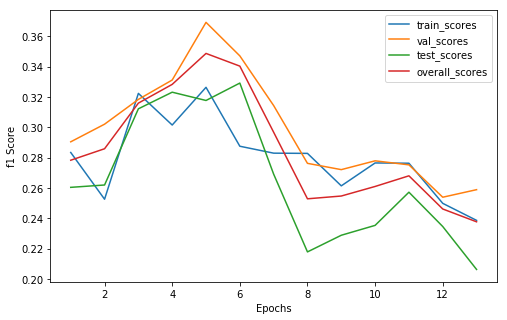

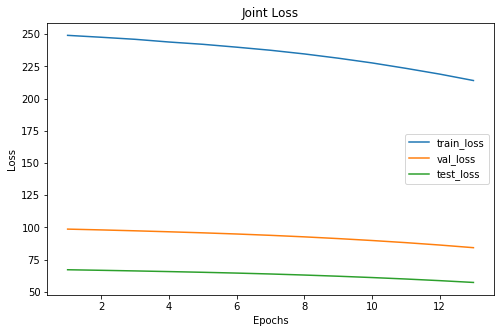

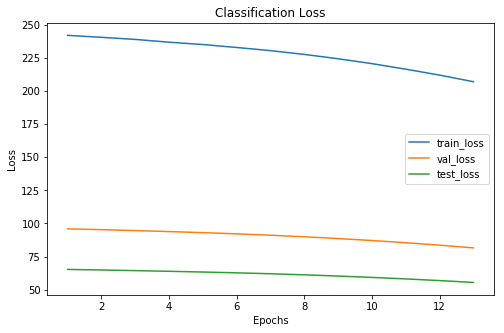

Cofusion Matrix For Val Set: 
-  --  --  -
0  20  25  0
0  19  32  4
0   3  22  5
0   0   0  0
-  --  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0        0      0       0
 1       99     42      29
 2      203     79      53
xxxxxxxxxxxxxx epoch: 3 xxxxxxxxxxxxxx


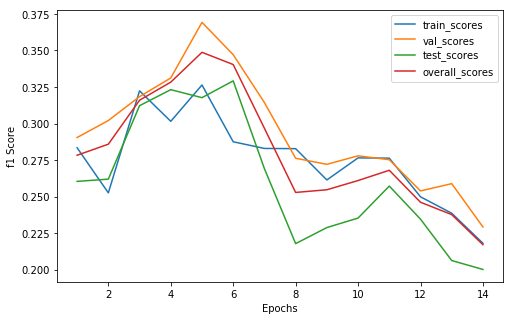

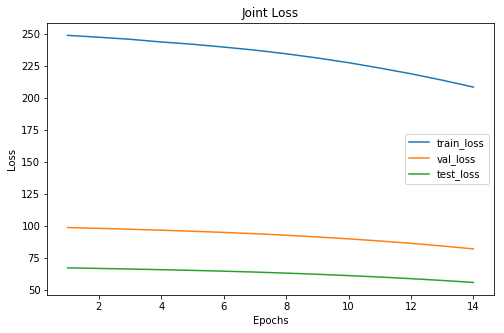

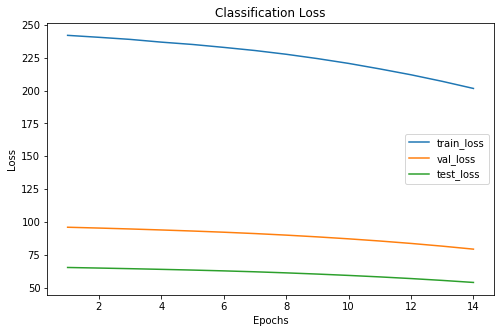

Cofusion Matrix For Val Set: 
-  --  --  -
0  17  28  0
0  14  37  4
0   1  24  5
0   0   0  0
-  --  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0        0      0       0
 1       87     32      24
 2      216     89      58
xxxxxxxxxxxxxx epoch: 4 xxxxxxxxxxxxxx


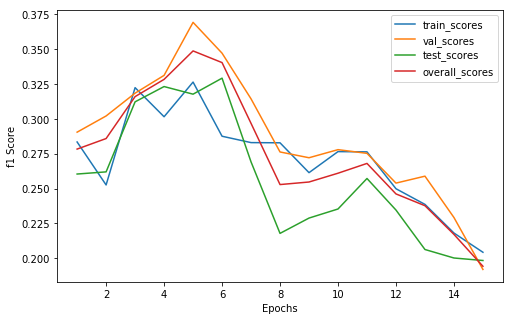

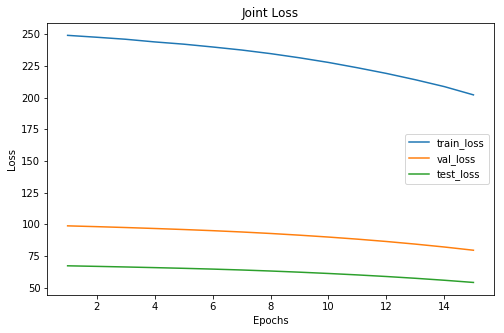

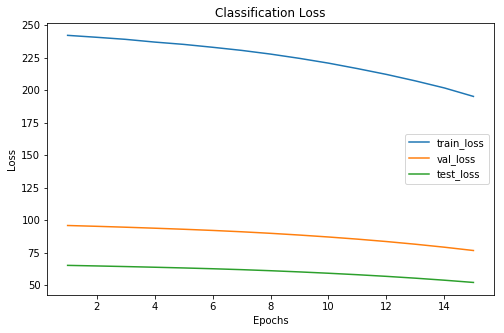

Cofusion Matrix For Val Set: 
-  --  --  -
0  17  28  0
0  10  41  4
0   1  24  5
0   0   0  0
-  --  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0        0      0       0
 1       83     28      21
 2      219     93      61
xxxxxxxxxxxxxx epoch: 5 xxxxxxxxxxxxxx


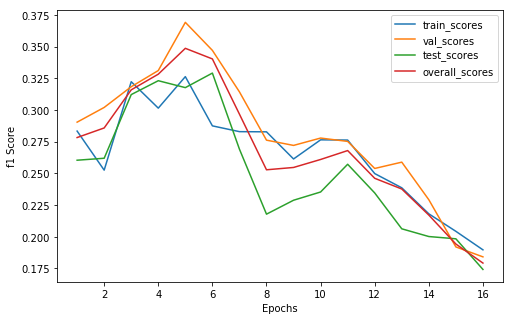

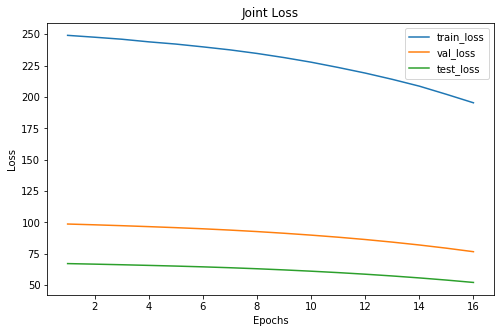

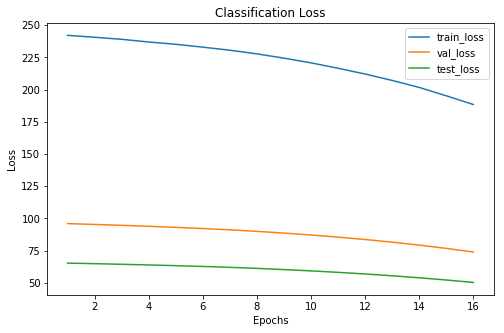

Cofusion Matrix For Val Set: 
-  --  --  -
0  13  32  0
0   9  42  4
0   1  24  5
0   0   0  0
-  --  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0        0      0       0
 1       68     23      19
 2      236     98      63
xxxxxxxxxxxxxx epoch: 6 xxxxxxxxxxxxxx


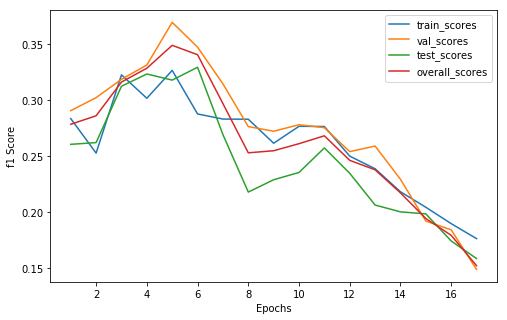

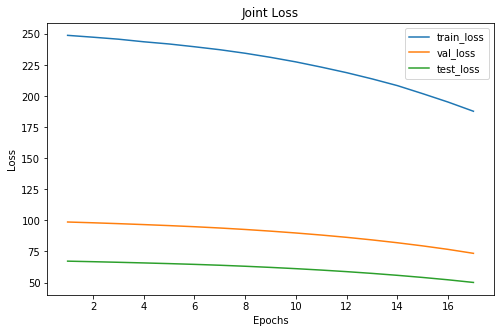

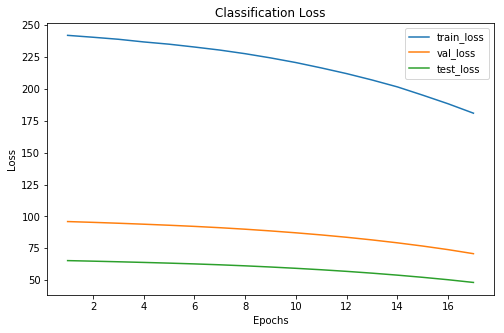

Cofusion Matrix For Val Set: 
-  --  --  -
0  15  30  0
0   6  45  4
0   1  23  6
0   0   0  0
-  --  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0        0      0       0
 1       58     22      18
 2      244     98      64
xxxxxxxxxxxxxx epoch: 7 xxxxxxxxxxxxxx


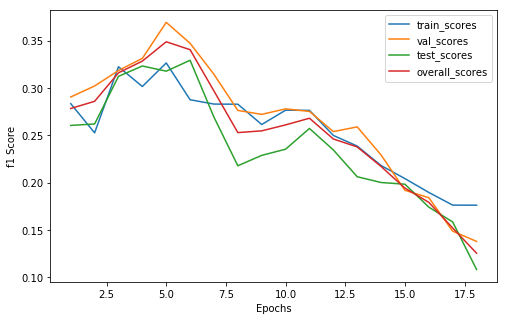

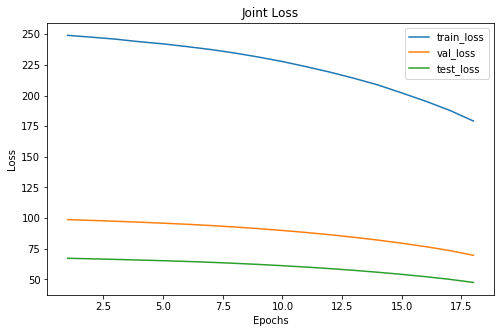

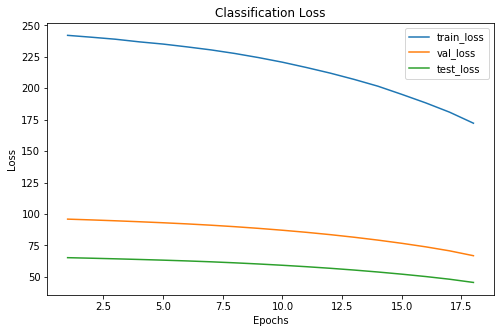

Cofusion Matrix For Val Set: 
-  --  --  -
0  14  31  0
0   5  46  4
0   1  23  6
0   0   0  0
-  --  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0        0      0       0
 1       54     20      15
 2      248    100      67


KeyboardInterrupt: 

In [7]:
# total_loss_over_epochs, scores_over_epochs = plotting.get_empty_stat_over_n_epoch_dictionaries()
# reconstruction_loss_over_epochs = deepcopy(total_loss_over_epochs)
# classification_loss_over_epochs = deepcopy(total_loss_over_epochs)
# validation_user_statistics_over_epochs = []


for epoch in range(300):
    
    (train_total_loss, train_total_reconstruction_loss , train_total_classification_loss, 
     train_labels, train_preds, train_users) = trainer.evaluate_multitask_learner(data, 
                                                                          'train_ids',
                                                                          num_classes,            
                                                                          model,
                                                                          reconstruction_criterion ,
                                                                          classification_criterion,
                                                                          device,            
                                                                          optimizer=optimizer,
                                                                          alpha=alpha,
                                                                          beta=beta,
                                                                          use_histogram=use_historgram,
                                                                          ordinal_regression=ordinal_regression)
    
    (val_total_loss, val_total_reconstruction_loss , val_total_classification_loss, 
     val_labels, val_preds, val_users) =  trainer.evaluate_multitask_learner(data,
                                                                  'val_ids',
                                                                  num_classes,  
                                                                  model,
                                                                  reconstruction_criterion,
                                                                  classification_criterion,
                                                                  device,            
                                                                  alpha=alpha,
                                                                  beta=beta,
                                                                  use_histogram=use_historgram,
                                                                  ordinal_regression=ordinal_regression)
    
    (test_total_loss, test_total_reconstruction_loss , test_total_classification_loss, 
     test_labels, test_preds, test_users) =  trainer.evaluate_multitask_learner(data, 
                                                                    'test_ids',
                                                                    num_classes,
                                                                    model,
                                                                    reconstruction_criterion,
                                                                    classification_criterion,
                                                                    device,
                                                                    alpha=alpha,
                                                                    beta=beta,
                                                                    use_histogram=use_historgram,
                                                                    ordinal_regression=ordinal_regression)
    
    ######## Appending losses ######## 
    total_loss_over_epochs['train_loss'].append(train_total_loss)
    total_loss_over_epochs['val_loss'].append(val_total_loss)
    total_loss_over_epochs['test_loss'].append(test_total_loss)
    
    reconstruction_loss_over_epochs['train_loss'].append(train_total_reconstruction_loss)
    reconstruction_loss_over_epochs['val_loss'].append(val_total_reconstruction_loss)
    reconstruction_loss_over_epochs['test_loss'].append(test_total_reconstruction_loss)
    
    classification_loss_over_epochs['train_loss'].append(train_total_classification_loss)
    classification_loss_over_epochs['val_loss'].append(val_total_classification_loss)
    classification_loss_over_epochs['test_loss'].append(test_total_classification_loss)

    
    ######## Appending Metrics ######## 
    val_label_list = conversions.tensor_list_to_int_list(val_labels)
    test_label_list = conversions.tensor_list_to_int_list(test_labels)
    val_pred_list = conversions.tensor_list_to_int_list(val_preds)
    test_pred_list = conversions.tensor_list_to_int_list(test_preds)
    over_all_label_list = val_label_list + test_label_list
    over_all_pred_list = val_pred_list + test_pred_list
    
    train_scores = metrics.precision_recall_fscore_support(conversions.tensor_list_to_int_list(train_labels),
                                                           conversions.tensor_list_to_int_list(train_preds), average='weighted')
    val_scores = metrics.precision_recall_fscore_support(val_label_list, val_pred_list, average='weighted')
    test_scores = metrics.precision_recall_fscore_support(test_label_list, test_pred_list, average='weighted')
    overall_scores = metrics.precision_recall_fscore_support(over_all_label_list, over_all_pred_list, average='weighted')

    scores_over_epochs['train_scores'].append(train_scores)
    scores_over_epochs['val_scores'].append(val_scores)
    scores_over_epochs['test_scores'].append(test_scores)
    scores_over_epochs['overall_scores'].append(overall_scores)
    
    validation_user_statistics_over_epochs.append(statistics.generate_training_statistics_for_user(val_labels, 
                                                                                                val_preds, 
                                                                                                val_users))

    if epoch%1 == 0:
        print("xxxxxxxxxxxxxx epoch: {} xxxxxxxxxxxxxx".format(epoch))
        plotting.plot_score_over_n_epochs(scores_over_epochs, score_type='f1', fig_size=(8,5))
        plotting.plot_loss_over_n_epochs(total_loss_over_epochs, fig_size=(8, 5), title="Joint Loss")
#         plotting.plot_loss_over_n_epochs(reconstruction_loss_over_epochs, fig_size=(8, 5), title="Reconstruction Loss")
        plotting.plot_loss_over_n_epochs(classification_loss_over_epochs, fig_size=(8, 5), title="Classification Loss")
        
        print("Cofusion Matrix For Val Set: ")
        print(tabulate( metrics.confusion_matrix(conversions.tensor_list_to_int_list(val_labels), 
                                                 conversions.tensor_list_to_int_list(val_preds))))
        print("Predicted Label Distribution:")
        print(statistics.get_train_test_val_label_counts_from_predictions(train_preds, val_preds, test_preds))
